### Load Frames of video

In [23]:
# from functions import *
from keras.saving import load_model
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(["baseball", "basketball", "billiard_ball", "bowling_ball", "cricket_ball", "football", "golf_ball", "hockey_ball", "table_tennis_ball", "tennis_ball", "volleyball"])


model = load_model("ball_cnn.keras")
# frames = load_images("data/optical_flow/tennis_ball")

### Extract Frames

In [19]:
import cv2


def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

### Predict label for each frame

In [24]:
import keras
from typing import Optional
from functions import *
import matplotlib.pyplot as plt
from sys import maxsize as max_int
import numpy as np
from tqdm import tqdm


def detect_circles(image: np.ndarray, max_radius: int, max_circles = max_int, threshold = 1) -> np.ndarray:
    circles: Optional[np.ndarray] = None
    threshold = 100
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    downsampled_image = downsample_image(image)
    blur = min(downsampled_image.shape) // 40
    blurred_image = cv2.blur(downsampled_image, (blur, blur))
    while True:
        circles = cv2.HoughCircles(
            blurred_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=min(blurred_image.shape) // 5,
            param1=threshold,
            param2=threshold,
            minRadius=50,
            maxRadius=max_radius
        )
        if circles is not None or threshold <= 5:
            break
        else:
            threshold -= 5
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
    else:
        circles = np.array([])

    return circles[:max_circles]


def identify_ball(model: keras.Sequential, image: np.ndarray, max_radius: int) -> tuple[str, int, np.ndarray]:
    # Preprocess the image
    circles = detect_circles(image, max_radius=max_radius, max_circles=5)
    cropped_images = crop_to_circle(image, circles)
    if not cropped_images:
        return None, "No ball detected", 0, None

    cropped_images, _ = downsample_images(cropped_images)
    cropped_images = circle_mask_images(cropped_images)
    # cropped_images = cropped_images.astype('float32') / 255.0
    if cropped_images.size == 0:
        return None, None, None

    predictions = model.predict(cropped_images, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_prob = np.max(predictions, axis=1)

    # Get the most confident prediction
    best_idx = np.argmax(predicted_prob)
    best_class = label_encoder.inverse_transform([predicted_class[best_idx]])[0]
    best_prob = predicted_prob[best_idx]

    return best_class, round(best_prob * 100), circles[best_idx]


def get_labels_and_circles(model: keras.Sequential, frames: list[np.ndarray], max_radius: int = 150) -> tuple[list[str], list[np.ndarray]]:
    labels = []
    circles = []
    for frame in tqdm(frames):
        label, prob, circle = identify_ball(model, frame, max_radius)
        name = f"{label} ({prob}%)"
        x, y, r = circle
        position = (x - 60, y + r + 40)
        labels.append((name, position))
        circles.append(circle)
    return labels, circles


### Optical Flow

In [13]:
import cv2
import numpy as np


# Create a color wheel legend for optical flow visualisation
# Shows the direction of travel in the image
def create_color_wheel():
    height, width = 100, 100
    color_wheel = np.zeros((height, width, 4), dtype=np.uint8)
    center = (width // 2, height // 2)
    max_radius = min(center[0], center[1], width - center[0], height - center[1])

    for y in range(height):
        for x in range(width):
            dx = x - center[0]
            dy = y - center[1]
            radius = np.sqrt(dx**2 + dy**2)
            if radius <= max_radius:
                angle = np.arctan2(dy, dx)
                angle = angle if angle >= 0 else angle + 2 * np.pi
                hue = angle * 180 / np.pi / 2
                saturation = 255
                value = 255 if radius <= max_radius else 0
                color = cv2.cvtColor(np.uint8([[[hue, saturation, value]]]), cv2.COLOR_HSV2BGR)[0][0]
                color_wheel[y, x] = np.append(color, 255) 
            else:
                color_wheel[y, x] = np.array([0, 0, 0, 0])

    return color_wheel


# allows for blending of images with alpha channel
def blend_with_alpha(frame, overlay, x, y):
    overlay_h, overlay_w = overlay.shape[:2]
    alpha_overlay = overlay[:, :, 3] / 255.0
    alpha_frame = 1.0 - alpha_overlay

    for c in range(0, 3):
        frame[y:y+overlay_h, x:x+overlay_w, c] = (alpha_overlay * overlay[:, :, c] + alpha_frame * frame[y:y+overlay_h, x:x+overlay_w, c])
        

# Visualise the optical flow
# first video is the background, second video is the optical flow
def visualise_optical_flow(common_path: str, video_path1: str, video_path2: str, labels: list[tuple[str, tuple[int, int]]]):
    # load the first videos
    cap1 = cv2.VideoCapture(common_path + video_path1)
    if not cap1.isOpened():
        print("Error: Could not open video 1.")
        return

    cap2 = cv2.VideoCapture(common_path + video_path2)
    if not cap2.isOpened():
        print("Error: Could not open video 2.")
        return

    # read the first frames
    ret1, original_frame = cap1.read()
    ret2, flow_frame = cap2.read()
    if not ret1 or not ret2:
        print("Error: Could not read the first frame of one or both videos.")
        return

    prev_grey = cv2.cvtColor(flow_frame, cv2.COLOR_BGR2GRAY)
    # Create a hsv mask image
    hsv_mask = np.zeros_like(flow_frame)
    hsv_mask[..., 1] = 255

    # Create the color wheel legend
    color_wheel = create_color_wheel()

    i = 0
    optical_flow_frames = []
    while True:
        # Read the next frames
        ret1, original_frame = cap1.read()
        ret2, flow_frame = cap2.read()
        if not ret1 or not ret2:
            break

        grey = cv2.cvtColor(flow_frame, cv2.COLOR_BGR2GRAY)

        # Compute the dense optical flow using the Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_grey, grey, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        # Compute the magnitude and angle of the flow vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Set the hue according to the direction and value according to magnitude
        hsv_mask[..., 0] = angle * 180 / np.pi / 2
        hsv_mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to BGR to be shown and overlay on orginal frame
        bgr_mask = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
        output = cv2.addWeighted(original_frame, 1, bgr_mask, 2, 0)

        # put the text for the prediction below the ball
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(output, labels[i][0], labels[i][1], font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Blend the color wheel with the output frame
        blend_with_alpha(output, color_wheel, 10, 10)
        text_x = (color_wheel.shape[1]) // 2 - 30
        text_y = 10 + color_wheel.shape[0] + 20
        cv2.putText(output, "directions", (text_x, text_y), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the result and update the previous frame
        cv2.imshow('Optical Flow', output)
        optical_flow_frames.append(output)
        prev_grey = grey

        # Exit if the user presses the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        i += 1

    # save_video(optical_flow_frames, "data/optical_flow/optical_flow.mp4")

    # Release the video capture objects and close windows
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()


In [5]:
frames = extract_frames("data/optical_flow/tennis.mp4")
print(f"Total number of frames extracted: {len(frames)}")

labels, circles = get_labels_and_circles(model, frames, 70)

Total number of frames extracted: 91


100%|██████████| 91/91 [00:14<00:00,  6.21it/s]


In [12]:
visualise_optical_flow("data/optical_flow/", "tennis.mp4", "tennis_masked.mp4", labels)

In [25]:
frames = extract_frames("data/optical_flow/basketball.mp4")
print(f"Total number of frames extracted: {len(frames)}")

labels, circles = get_labels_and_circles(model, frames, 200)


Total number of frames extracted: 92


100%|██████████| 92/92 [00:12<00:00,  7.40it/s]


In [26]:
visualise_optical_flow("data/optical_flow/", "basketball.mp4", "basketball_masked.mp4", labels)

### Save Frames

In [ ]:
import os

def save_frames(frames, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for i, frame in enumerate(frames):
        frame_path = os.path.join(folder_path, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path, np.array(frame))

# Specify the folder path where you want to save the frames
folder_path = "data/optical_flow/tennis_ball"
save_frames(frames, folder_path)
print(f"Frames saved to folder: {folder_path}")

### Mask Images

- use the ball detection to mask the ball in the image

100%|██████████| 92/92 [00:00<00:00, 1116.77it/s]


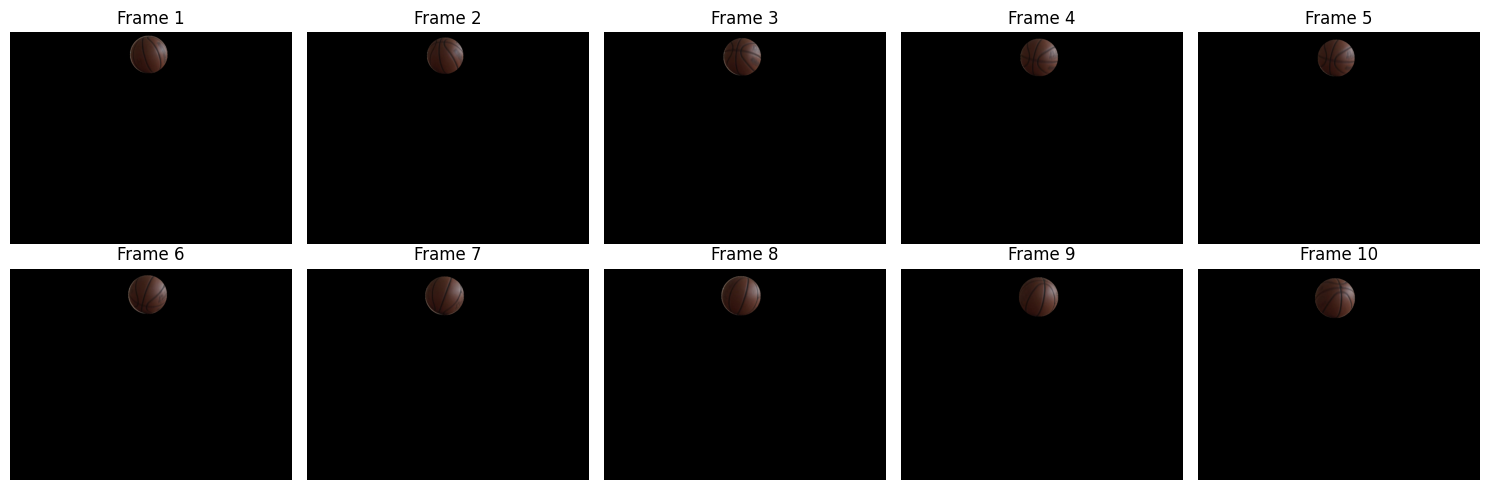

In [16]:
def mask_images(frames: list[np.ndarray], circles: list[tuple[int, int, int]]) -> list[np.ndarray]:    
    masked_frames = []
    frames_with_circles = list(zip(frames, circles))
    for frame, (x, y, r) in tqdm(frames_with_circles):
        mask = np.zeros_like(frame)
        cv2.circle(mask, (x, y), r, (255, 255, 255), thickness=-1)
        masked_frame = cv2.bitwise_and(frame, mask)
        masked_frames.append(masked_frame)

    # Display the first masked frame as an example
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        if i < len(masked_frames):
            ax.imshow(cv2.cvtColor(masked_frames[i], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Frame {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return masked_frames


masked_frames = mask_images(frames, circles)

### Save as video

In [8]:
def save_video(frames, output_path, fps=30):
    height, width, layers = frames[0].shape
    size = (width, height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, size)

    for frame in frames:
        out.write(frame)

    out.release()

# Specify the output video path
output_video_path = "data/optical_flow/basketball_masked.mp4"
save_video(masked_frames, output_video_path)
print(f"Video saved to: {output_video_path}")

Video saved to: data/optical_flow/basketball_masked.mp4


### New Video Setup

Error: Could not open video.
Total number of frames extracted: 0


0it [00:00, ?it/s]
0it [00:00, ?it/s]


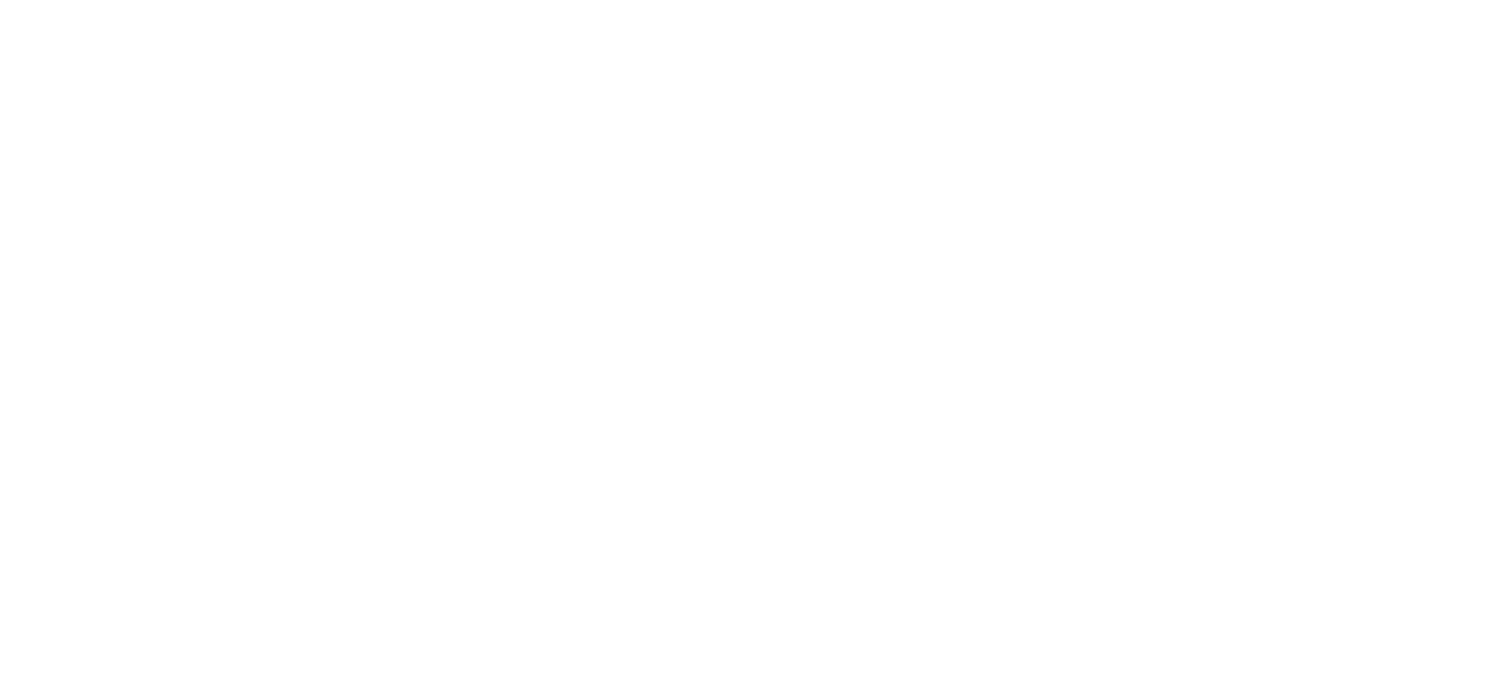

NameError: name 'save_video' is not defined

In [17]:
video_name = "billiard"
frames = extract_frames(f"data/optical_flow/{video_name}.mp4")
print(f"Total number of frames extracted: {len(frames)}")

labels, circles = get_labels_and_circles(model, frames)
masked_frames = mask_images(frames, circles)
save_video(masked_frames, f"data/optical_flow/{video_name}_masked.mp4")


100%|██████████| 91/91 [00:00<?, ?it/s]


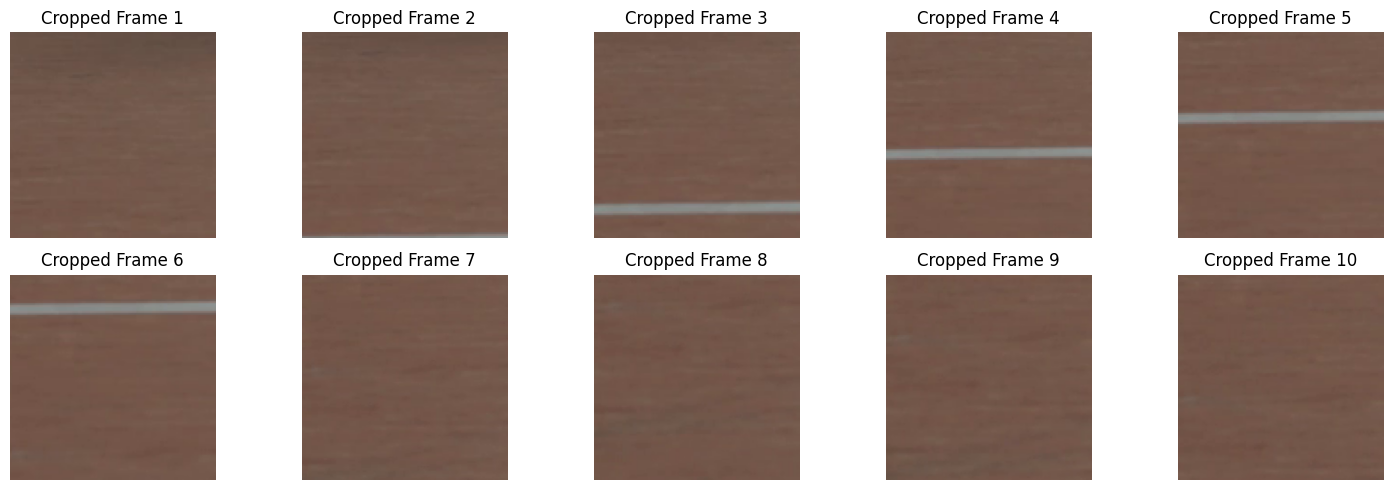

Cropped frames saved to folder: data/optical_flow/cropped_frames


In [22]:
def crop_to_circle1(img: np.ndarray, circle: np.ndarray) -> np.ndarray:
    cropped_imgs = []
    if circle is not None:
        x, y, r = circle
        cropped_img = img[y-r:y+r, x-r:x+r]
        cropped_imgs.append(cropped_img)
    return cropped_imgs

frames_with_circles = list(zip(frames, circles))
cropped_frames = []
for frame, circle in tqdm(frames_with_circles):
    cropped_frames.append(crop_to_circle1(frame, circle))

# Display the first few cropped frames as an example
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    if i < len(cropped_frames):
        ax.imshow(cv2.cvtColor(cropped_frames[i][0], cv2.COLOR_BGR2RGB))
        ax.set_title(f"Cropped Frame {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

def save_frames(frames, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    for i, frame_list in enumerate(frames):
        for j, frame in enumerate(frame_list):
            frame_path = os.path.join(folder_path, f"frame_{i:04d}_{j:02d}.jpg")
            cv2.imwrite(frame_path, frame)

# Specify the folder path where you want to save the cropped frames
cropped_folder_path = "data/optical_flow/cropped_frames"
save_frames(cropped_frames, cropped_folder_path)
print(f"Cropped frames saved to folder: {cropped_folder_path}")